## Chapter 9: Algorithm Analysis (Updated Oct. 5)

*Definition*: Consider two functions $f$ and $g$. We say that $f(n)$ is $O(g(n))$ or “big-O” of $g(n)$ if

$$ \lim_{n \rightarrow \infty} f(n) = C$$

for some $0<C<\infty$

Find big-O for the following:
* $n^2+e^n$
* $3n^2+e^{-n}$
* $n + n \ln (n)$

### Polynomial Evaluation

Recall that a polynomial is

$$p(x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots + a_n x^n$$

For example, a quadratic is a polynomial like $q(x)= 3x^2+7x-2$

The simple way to evaluate the polynomial is to find each power of x and then multiply by the coefficient.  Here's a function that takes an array of coefficients and a value $x$ and calculates $p(x)$.  

In [1]:
function polyEval(coeffs::Vector{T}, x::S) where {T <: Number, S <: Number}
  local sum = zero(T)
  
  # we will use a simple power function that is not very efficient:
  function pow(x::T,n::Int) where T <: Number
    local prod = one(T)
    for j=1:n
      prod *=x
    end
    prod
  end
    
  # then we have the sum of all of the terms:
  for n=1:length(coeffs)
    sum += coeffs[n]*pow(x,n-1)
  end
  sum
end

polyEval (generic function with 1 method)

note: we will be explaining the `where {T <: Number, S <: Number}` later.  This allows the ability to evaluate polynomials at any type of number. 

The following evaluates $q(1.5)$ for the quadratic above

In [2]:
polyEval([-2,7,3],1.5)

15.25

And here is the polynomial $p(x)=1+2x+3x^2+4x^3$ evaluated at $x=4$

In [4]:
polyEval([1,2,3,4],4)

313

We want to see how polynomial evaluation occurs for a given value of $n$, the degree of the polynomial.  We can do this two different ways:

1. Use some analytic techniques
2. Run some code and analyze.

For #1, we note that the number of multiplications for evaluating a polynomial of degree $n$ is

$$0+1+2+3+4+\cdots+(n+1)= \frac{(n+1)(n+2)}{2}$$

The number of additions is $n$. Overall the number of operations then is

$$\frac{(n+1)(n+2)}{2} +n$$

What is the order (big-o) of this?

For #2, we will do the following.  First need to load (and probably add) some packages

In [5]:
using BenchmarkTools, Plots, LsqFit

┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1278


The following make an array of times that store the evaluate times of the polynomial evaluation.  Although we only fill part of the 

In [61]:
times = zeros(Float64,300)
for i=50:50:300
  coeffs = rand(Float64,i)
  times[i] = @belapsed polyEval($coeffs,1/3)
end

In [62]:
times[50:50:300]

6-element Array{Float64,1}:
 4.964896907216495e-7
 2.628222222222222e-6
 6.75e-6
 1.4226e-5
 2.2136e-5
 3.5935e-5

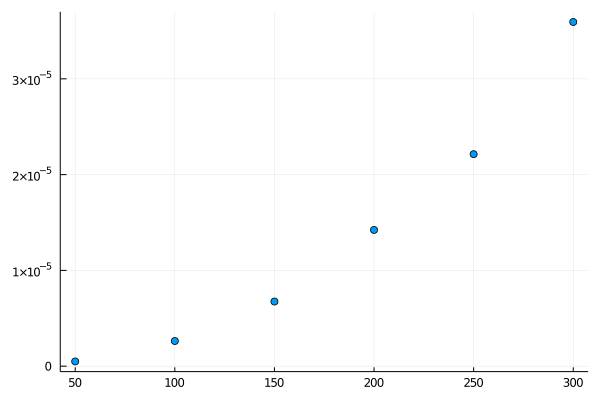

In [74]:
scatter(50:50:300,times[50:50:300],legend=false)

Although this looks quadratic, let's see if it is.  We can find the data to a quadratic using the following:

In [75]:
 model(t, p) = p[1].+p[2].*t.+p[3].*t.^2

model (generic function with 1 method)

In [76]:
fit = curve_fit(model, 50:50:300, times[50:50:300], [1e-8,1e-8,1e-8]);

And if we want the parameters

In [77]:
fit.param

3-element Array{Float64,1}:
  1.6243012599084982e-6
 -4.4756275026456074e-8
  5.249230467384012e-10

The following is the confidence intervals for each of the paramters. 

In [78]:
confidence_interval(fit, 0.05)

3-element Array{Tuple{Float64,Float64},1}:
 (-2.8748760012684373e-6, 6.123478521085434e-6)
 (-1.036259691176035e-7, 1.4113419064691347e-8)
 (3.602700185862405e-10, 6.895760748905619e-10)

Because the first two contain 0, we don't include them and only use the 3rd (which is the $x^2$ term):

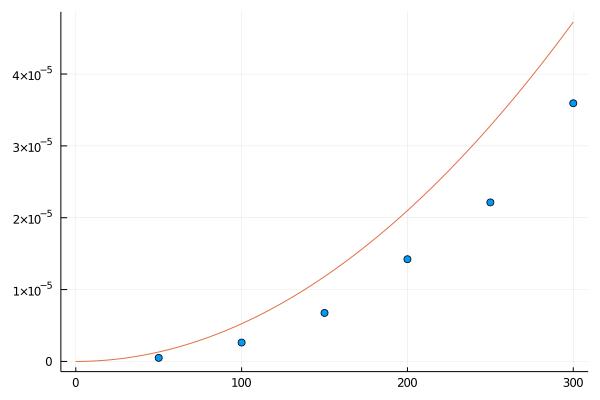

In [79]:
plot!(n->fit.param[3]*n^2,0:300)

Next, we are going to do an alternative way of evaluating a polynomial.  This is called Horner's form. 

The polynomial

$$p(x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots + a_n x^n$$

can be written:

$$(a_n x +a_{n-1})x + a_{n-2})x + \cdots + a_2)x^2 + a_1)x + a_0$$ 

and the result is that there are $n$ multiplications and $n$ additions. So this should be faster.

In [80]:
function horner(coeffs::Vector{T},x::S) where {T <: Number, S <: Number}
  result = coeffs[end] 
  for i=length(coeffs)-1:-1:1
    result = x*result+coeffs[i]
  end
  result
end

horner (generic function with 1 method)

In [81]:
htime = zeros(Float64,300)
for i=50:50:300
  coeffs = rand(Float64,i)
  htime[i] = @belapsed horner($coeffs,1/3)
end

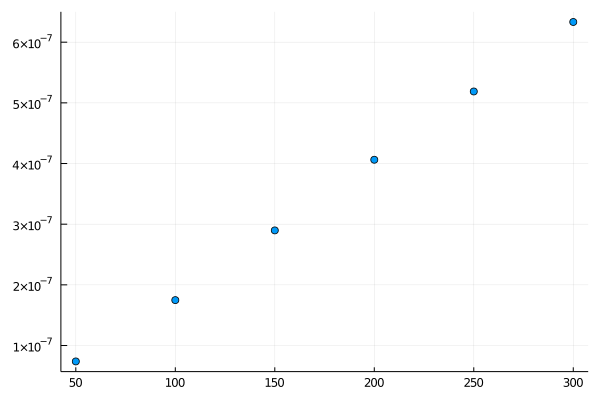

In [83]:
scatter(50:50:300,htime[50:50:300],legend=false)

In [87]:
fit2 = curve_fit(model, 50:50:300, htime[50:50:300], [1e-8,1e-8,1e-8]);

In [88]:
fit2.param

3-element Array{Float64,1}:
 -3.55215488868575e-8
  2.110297331284545e-9
  4.1282796054093516e-13

In [89]:
confidence_interval(fit2)

3-element Array{Tuple{Float64,Float64},1}:
 (-5.7290438312830476e-8, -1.3752659460884521e-8)
 (1.8254612853102617e-9, 2.395133377258828e-9)
 (-3.838318186646494e-13, 1.2094877397465198e-12)

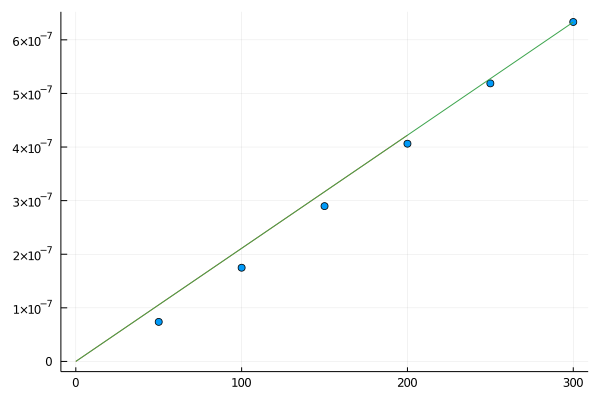

In [91]:
plot!(n->fit2.param[2]*n,0:300)

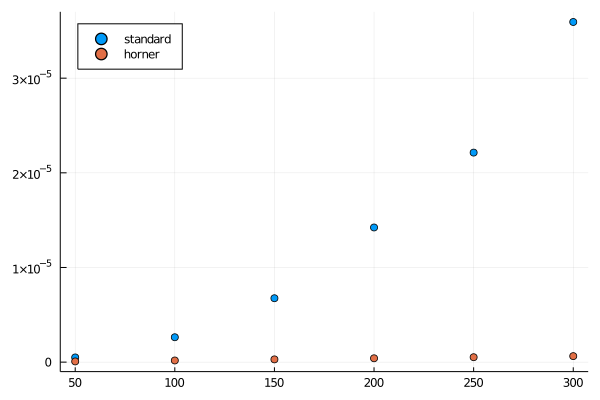

In [94]:
scatter(50:50:300,times[50:50:300],label="standard",legend=:topleft)
scatter!(50:50:300,htime[50:50:300],label="horner")

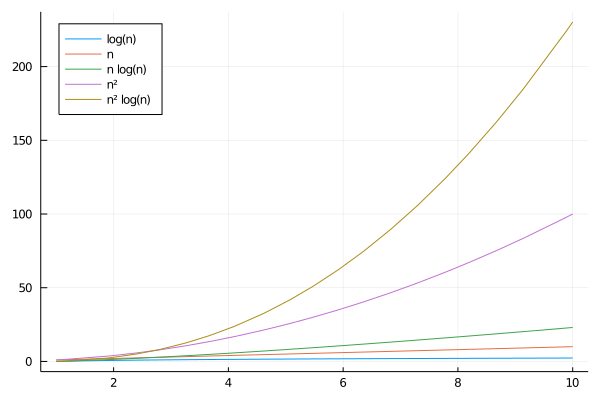

In [21]:
plot([x->log(x),x->x,x->x*log(x),x->x^2,x->x^2*log(x)],1,10,
    label=["log(n)" "n" "n log(n)"  "n²" "n² log(n)"],
    legend=:topleft)

### Testing the speed of Primes

In [95]:
function isPrime5(n::Integer)
  if n%2==0
    return false
  end
  for k=3:2:round(Int,sqrt(n))
    if n%k==0
      return false
    end
  end
  true
end

isPrime5 (generic function with 1 method)

In [96]:
using Primes

In [110]:
prime_range = 5_000_000:5_000_000:100_000_000

5000000:5000000:100000000

In [111]:
the_primes = map(nextprime,prime_range)
prime_times=zeros(Float64,length(the_primes))
for i=1:length(the_primes)
  prime_times[i] = @belapsed isPrime5($the_primes[$i])
end

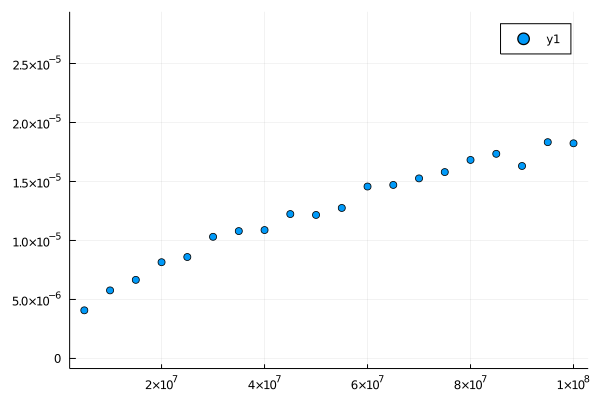

In [140]:
scatter(prime_range,times)

In [141]:
 model2(t, p) = p[1].+p[2].*sqrt.(t).+p[3]*log.(t)

model2 (generic function with 1 method)

In [142]:
fit3 = curve_fit(model2,1:length(prime_times), prime_times, [1e-4, 1e-4,1e-4]);

In [143]:
fit3.param

3-element Array{Float64,1}:
 -6.93817835329159e-7
  2.84049718138914e-6
 -8.027861682381316e-7

In [144]:
confidence_interval(fit3)

3-element Array{Tuple{Float64,Float64},1}:
 (-1.3313012904272518e-6, -5.6334380231066335e-8)
 (1.996135515639505e-6, 3.6848588471387753e-6)
 (-1.8651244918497576e-6, 2.595521553734943e-7)

Only the $\sqrt{n}$ term is significant.  Let's fit the model to just that one:

In [150]:
model3(t,p) = p[1].*sqrt.(t)

model3 (generic function with 1 method)

In [152]:
fit4 = curve_fit(model3,1:length(prime_times),prime_times,[1e-6]);

In [154]:
fit4.param

1-element Array{Float64,1}:
 2.0786902598406015e-6

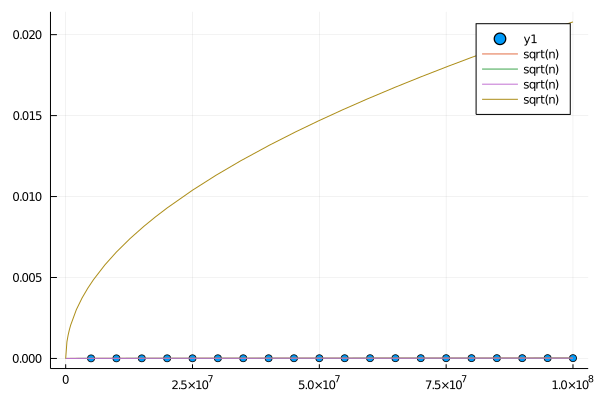

In [155]:
plot!(t->fit4.param[1]*sqrt(t),1,100_000_000,label="sqrt(n)")

In [156]:
fit4.resid

20-element Array{Float64,1}:
  1.554680376183794e-7
  5.560084632832039e-8
  6.652214324247301e-8
  7.86305196812032e-8
  3.485212965988577e-7
  9.644475561713748e-8
  1.0369748027046665e-7
  4.395905815455303e-7
  1.199041128551382e-7
  1.233957711035383e-7
  5.170356472576468e-7
  1.3759428648494668e-7
  1.4422431766285097e-7
 -3.472532344523694e-7
 -9.460057504711619e-8
  1.5776103936240581e-7
 -1.000904957345792e-7
  1.6646920565162838e-7
  1.7113411090082145e-7
 -1.4548145496594272e-6

In [149]:
fit3.param

3-element Array{Float64,1}:
 -6.93817835329159e-7
  2.84049718138914e-6
 -8.027861682381316e-7